In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
import os
import json
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
#summary
from torchinfo import summary

2025-03-15 20:45:26.294032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 20:45:26.301074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742046326.309708   24048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742046326.312214   24048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 20:45:26.321546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
MODEL_NAME = 'kornwtp/ConGen-model-XLMR'

model_encode = SentenceTransformer(f'{MODEL_NAME}')

In [3]:
sentences = ["กลุ่มผู้ชายเล่นฟุตบอลบนชายหาด", "กลุ่มเด็กชายกำลังเล่นฟุตบอลบนชายหาด"]
sen = "เห็นด้วย เพราะการทำ AB Testing จะทำให้เห็นความแตกต่างอย่างชัดเจนว่า Conversion ส่งผลหรือไม่ อีกทั้งการทำ AB Testing จะช่วยลดผลกระทบจาก Randomness เพราะทำพร้อม ๆ กันจะได้รับผลกระทบจาก randomness ที่พอๆ กัน"
sen2 = sen*4
embeddings = model_encode.encode(sen)
print(embeddings.shape)

print(len(sen))
tk = model_encode.tokenize(sen)
# print(tk['input_ids'])

tokenizer = model_encode.tokenizer
b = tokenizer.encode_plus(sen2, padding='max_length', truncation=False, return_tensors='pt')
print(b['input_ids'])
print(b['input_ids'].shape)

# reverse
re = tokenizer.decode(b['input_ids'][0])
print(re)

# get embeddings
embeddings = model_encode.encode(re, convert_to_tensor=True, device='cuda')
print(type(embeddings))
print(embeddings.device)

(768,)
204
tensor([[     0, 117689,   3918,  10953,  77141,  11321,   8647,    214,      6,
          78824,  19575,   4260, 137080,   5943, 110859,   2469,   1657,  46354,
              6, 207604,  49583,      6,   8690,   9231,  77141,  11321,   8647,
            214,  19818, 201166, 150721,   2607,  39643,    306,   7432,  10953,
           5819,  18538,   7790, 105005, 110651, 150721,   2607,  96759,   7432,
           5261,  30423,   3354, 105005,  19575,   3918,  10953,  77141,  11321,
           8647,    214,      6,  78824,  19575,   4260, 137080,   5943, 110859,
           2469,   1657,  46354,      6, 207604,  49583,      6,   8690,   9231,
          77141,  11321,   8647,    214,  19818, 201166, 150721,   2607,  39643,
            306,   7432,  10953,   5819,  18538,   7790, 105005, 110651, 150721,
           2607,  96759,   7432,   5261,  30423,   3354, 105005,  19575,   3918,
          10953,  77141,  11321,   8647,    214,      6,  78824,  19575,   4260,
         137080, 

In [4]:
# Linear 768 -> 256 -> 5 [logits]
class myModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim, model_name, tokenizer):
        super(myModel, self).__init__()
        self.encoder = SentenceTransformer(model_name)
        self.linear0 = torch.nn.Linear(768, 768)
        self.linear = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, output_dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.1)
        self.tokenizer = tokenizer

    def forward(self, x):
        x = self.encoder.encode(tokenizer.batch_decode(x), convert_to_tensor=True, device='cuda')
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [5]:
a = [1, 2, 3]
a = tuple(a)
print(a)

(1, 2, 3)


In [6]:
a = 4.5
idx = int(a*2)
print(idx)

9


In [7]:

def load_dataset(qset, tokenizer, raw=False):
    train_csv = pd.read_csv(f'./dataset/processed/train_Q{qset}.csv')
    test_csv = pd.read_csv(f'./dataset/processed/test_Q{qset}.csv')
    val_csv = pd.read_csv(f'./dataset/processed/valid_Q{qset}.csv')

    X_train = train_csv['answer'].tolist()
    Y_train = train_csv['score'].tolist()
    X_val = val_csv['answer'].tolist()
    Y_val = val_csv['score'].tolist()
    X_test = test_csv['answer'].tolist()
    X_id = test_csv['ID'].tolist()
    alll = []
    for y in Y_train:
        alll.append(y)
    for y in Y_val:
        alll.append(y)
    unk = np.unique(alll)
    print(unk)
    mapp = {}
    for i, u in enumerate(unk):
        mapp[u] = i
    print(mapp)

    couu = np.zeros(len(unk))
    Y_train_out = np.zeros((len(Y_train), len(unk)))
    Y_val_out = np.zeros((len(Y_val), len(unk)))
    for i, y in enumerate(Y_train):
        idx = mapp[y]
        Y_train_out[i][idx] = 1
        couu[idx] += 1
    for i, y in enumerate(Y_val):
        idx = mapp[y]
        Y_val_out[i][idx] = 1
    
    ma = 0
    for x in X_train:
        tk = tokenizer.encode_plus(x, padding='max_length', truncation=False, return_tensors='pt')
        ma = max(ma, tk['input_ids'].shape[1])
    for x in X_val:
        tk = tokenizer.encode_plus(x, padding='max_length', truncation=False, return_tensors='pt')
        ma = max(ma, tk['input_ids'].shape[1])
    for x in X_test:
        tk = tokenizer.encode_plus(x, padding='max_length', truncation=False, return_tensors='pt')
        ma = max(ma, tk['input_ids'].shape[1])
    print(ma)

    X_train_out = []
    X_val_out = []
    X_test_out = []
    for x in X_train:
        tk = tokenizer.encode_plus(x, padding='max_length', truncation=False, return_tensors='pt',max_length=ma)
        X_train_out.append(tk['input_ids'][0])
    for x in X_val:
        tk = tokenizer.encode_plus(x, padding='max_length', truncation=False, return_tensors='pt',max_length=ma)
        X_val_out.append(tk['input_ids'][0])
    for x in X_test:
        tk = tokenizer.encode_plus(x, padding='max_length', truncation=False, return_tensors='pt',max_length=ma)
        X_test_out.append(tk['input_ids'][0])

    return np.array(X_train_out), Y_train_out, np.array(X_val_out), Y_val_out, np.array(X_test_out), X_id, couu, unk
    

# Dataset

In [78]:
question_set = 4

In [79]:
X_train_1, Y_train_1, X_val_1, Y_val_1, X_test_1, X_test_id, couu, unk = load_dataset(question_set, tokenizer, raw=False)
print(couu)
entro_weight = couu.sum() / (couu*11)
print(entro_weight)
train_dataset = CustomDataset(X_train_1, Y_train_1)
val_dataset = CustomDataset(X_val_1, Y_val_1)

print(X_train_1.shape, Y_train_1.shape, X_val_1.shape, Y_val_1.shape, X_test_1.shape, X_test_id)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# print(X_train_1.shape, Y_train_1.shape, X_val_1.shape, Y_val_1.shape, X_test_1.shape)

# print(np.unique(Y_train_1))
# print(np.unique(Y_val_1))

a = next(iter(train_loader))
print(a[0].shape, a[1].shape)
aa = a[0].reshape(-1)
print(aa.shape)
re = tokenizer.batch_decode(a[0])
print(len(re))
out = model_encode.encode(re)
print(out.shape)

[0.  0.5 1.  2.  3.  4.  4.5 5. ]
{0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3, 3.0: 4, 4.0: 5, 4.5: 6, 5.0: 7}
339
[ 1.  1.  9.  1. 11.  6.  1. 55.]
[7.72727273 7.72727273 0.85858586 7.72727273 0.70247934 1.28787879
 7.72727273 0.14049587]
(85, 339) (85, 8) (6, 339) (6, 8) (22, 339) [363, 366, 373, 376, 377, 380, 383, 386, 393, 396, 397, 399, 404, 410, 411, 419, 423, 432, 439, 444, 445, 451]
torch.Size([32, 339]) torch.Size([32, 8])
torch.Size([10848])
32
(32, 768)


In [80]:
# test

a = train_dataset[0]
# print(a[0].shape, a[1])
print(a[0])
outt = model_encode.encode(tokenizer.decode(a[0]))
print(outt.shape)

[     0    836 128415  80108   3641  21222  14793  12848    699 133354
  80108  20966  21222   5451 192557  15816 137551  34851  38937  13366
  21685  13687   6715     15  66140    699  62514  44792     16 116195
  18729  13601 150721   6938 144155 114435   5407   8482   2248  74957
  80108   3641  21222      6 192557 186746  26030   2386  87875  17140
  18310    699 110651 150721  51754  11165 168046  80108  20966  21222
      6  54378 101911  23609  12848  31700 108952   2248  74957  10953
  10699  70485   7526  57467   2859   3356 128548  10818  23075  19184
   1805  44824    106   6976 120980  17293   2859  32404   1834    699
  38937      6 199364 176469   3354 116195  13601 150721   5943   9438
  48484   6938  23539   1037  10699  70485      2      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      

In [81]:
print(couu)
couuu = couu+3
entro_weight = couuu.sum() / (couuu*11)
print(entro_weight)

[ 1.  1.  9.  1. 11.  6.  1. 55.]
[2.47727273 2.47727273 0.82575758 2.47727273 0.70779221 1.1010101
 2.47727273 0.17084639]


In [82]:
model = myModel(768, len(unk), MODEL_NAME, tokenizer)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(entro_weight).float().to("cuda"))
criterion_val = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
device = 'cuda'
epochs = 100

model.to(device)

myModel(
  (encoder): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
    (2): Dense({'in_features': 768, 'out_features': 768, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  )
  (linear0): Linear(in_features=768, out_features=768, bias=True)
  (linear): Linear(in_features=768, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=8, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [83]:
print(model.parameters)

<bound method Module.parameters of myModel(
  (encoder): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
    (2): Dense({'in_features': 768, 'out_features': 768, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  )
  (linear0): Linear(in_features=768, out_features=768, bias=True)
  (linear): Linear(in_features=768, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=8, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)>


In [84]:
ma = 267
foo = torch.zeros((32, ma), dtype=torch.int64)
print(foo.dtype)

# freeze encoder
# for param in model.encoder.parameters():
#     param.requires_grad = False

summary(model, input_data=foo)

torch.int64


Layer (type:depth-idx)                                                      Output Shape              Param #
myModel                                                                     [32, 8]                   --
├─SentenceTransformer: 1-1                                                  --                        --
│    └─Transformer: 2-1                                                     [32, 128, 768]            --
│    │    └─XLMRobertaModel: 3-1                                            [32, 128, 768]            278,043,648
│    └─Pooling: 2-2                                                         [32, 768]                 --
│    └─Dense: 2-3                                                           [32, 768]                 --
│    │    └─Linear: 3-2                                                     [32, 768]                 590,592
│    │    └─Tanh: 3-3                                                       [32, 768]                 --
├─Linear: 1-2                       

In [85]:
train_loss_all = []
val_loss_all = []
for i in tqdm(range(epochs)):
    # Learning Rate
    # print(optimizer.param_groups[0]['lr'])
    model.train()
    train_loss = []
    for X_batch, Y_batch in train_loader:
        # print(len(X_batch), len(Y_batch))
        # X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        X_batch, Y_batch = np.array(X_batch), Y_batch.to(device)
        optimizer.zero_grad()
        # print(X_batch.shape)
        output = model(X_batch)
        # print(output.dtype, Y_batch.dtype)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    # print(f'Epoch: {i} Train Loss: {np.mean(train_loss)}')
    train_loss_all.append(np.mean(train_loss))

    model.eval()
    with torch.no_grad():
        val_loss = []
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch)
            loss = criterion_val(output, Y_batch)
            val_loss.append(loss.item())
        # print(f'Epoch: {i} Val Loss: {np.mean(val_loss)}')
        lr_scheduler.step()
        val_loss_all.append(np.mean(val_loss))


100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


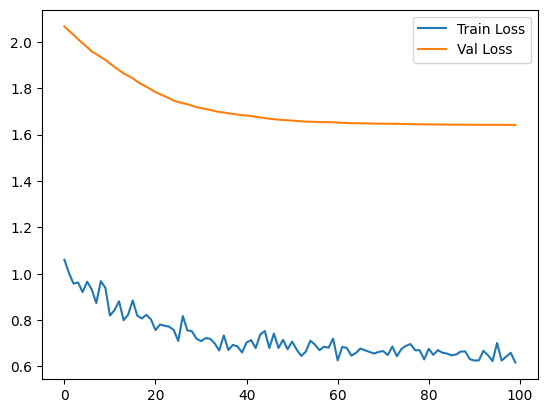

In [86]:
plt.plot(train_loss_all, label='Train Loss')
plt.plot(val_loss_all, label='Val Loss')
plt.legend()

In [87]:
val_0 = train_dataset[80]
print(val_0[0].shape)
print(np.argmax(val_0[1]))
inp = torch.tensor(val_0[0].reshape(1, -1)).to(device)
model.eval()
out = model(inp)
print(torch.argmax(out, dim=1))

(339,)
5
tensor([7], device='cuda:0')


In [95]:
use_set = train_dataset
pred = []
true = []
for i in range(len(use_set)):
    val_0 = use_set[i]
    inp = torch.tensor(val_0[0].reshape(1, -1)).to(device)
    model.eval()
    out = model(inp)
    sc = torch.tensor(unk).to(device)

    outt = torch.nn.functional.softmax(out*4.5, dim=1)
    # print(outt)
    scc = torch.sum(outt*sc, dim=1)
    print(f'Predict: {scc.item()} True: {unk[np.argmax(val_0[1])]}')
    pred.append(scc.item())
    true.append(unk[np.argmax(val_0[1])])

loss_fn = torch.nn.MSELoss()
loss = loss_fn(torch.tensor(pred), torch.tensor(true))
print(loss.item())

Predict: 4.998141577043828 True: 5.0
Predict: 4.976334883693411 True: 5.0
Predict: 4.267489407370476 True: 5.0
Predict: 4.9995953963594575 True: 5.0
Predict: 4.86050906056721 True: 5.0
Predict: 4.891137140586437 True: 5.0
Predict: 4.955618075541224 True: 5.0
Predict: 4.988368973629664 True: 5.0
Predict: 4.980190352078033 True: 5.0
Predict: 4.507598659868563 True: 5.0
Predict: 4.997659368576231 True: 5.0
Predict: 4.731743335130091 True: 5.0
Predict: 4.575542060571024 True: 5.0
Predict: 4.504279401220629 True: 5.0
Predict: 4.99931504036616 True: 5.0
Predict: 4.991416050094078 True: 5.0
Predict: 4.946509219111931 True: 5.0
Predict: 4.985811928720921 True: 5.0
Predict: 4.993489644135543 True: 5.0
Predict: 4.528714690816287 True: 5.0
Predict: 4.508215126358323 True: 5.0
Predict: 4.894632403915978 True: 5.0
Predict: 4.9995623485360134 True: 5.0
Predict: 4.985833257986862 True: 5.0
Predict: 4.854458677337153 True: 5.0
Predict: 4.826123390253997 True: 5.0
Predict: 4.9856228398249876 True: 5.0


In [96]:
output_path = f"./output2/Q{question_set}.csv"
output = []
for i in range(len(X_test_1)):
    val_0 = use_set[i]
    inp = torch.tensor(val_0[0].reshape(1, -1)).to(device)
    model.eval()
    out = model(inp)
    sc = torch.tensor(unk).to(device)
    outt = torch.nn.functional.softmax(out*4.5, dim=1)
    scc = torch.sum(outt*sc, dim=1)
    output.append([X_test_id[i], scc.item()])

df = pd.DataFrame(output, columns=['ID', 'Score'])
df.to_csv(output_path, index=False)
print(df)


     ID     Score
0   363  4.998142
1   366  4.976335
2   373  4.267489
3   376  4.999595
4   377  4.860509
5   380  4.891137
6   383  4.955618
7   386  4.988369
8   393  4.980190
9   396  4.507599
10  397  4.997659
11  399  4.731743
12  404  4.575542
13  410  4.504279
14  411  4.999315
15  419  4.991416
16  423  4.946509
17  432  4.985812
18  439  4.993490
19  444  4.528715
20  445  4.508215
21  451  4.894632


In [99]:
sets = [1, 2, 3, 4]
all_out = []
coll = ['ID', 'Score']
for s in sets:
    output_path = f"./output2/Q{s}.csv"
    df = pd.read_csv(output_path)
    sc, idd = df['Score'].tolist(), df['ID'].tolist()
    for i in range(len(sc)):
        all_out.append([idd[i], sc[i]])

all_out = sorted(all_out, key=lambda x: x[0])

df = pd.DataFrame(all_out, columns=coll)
df.to_csv('./output2/all.csv', index=False)
print(df)

     ID     Score
0   362  3.771651
1   363  4.998142
2   364  3.003294
3   365  4.727075
4   366  4.976335
..  ...       ...
85  447  3.677685
86  448  1.233329
87  449  1.416356
88  450  1.211991
89  451  4.894632

[90 rows x 2 columns]
